<a href="https://colab.research.google.com/github/shkumar156/Cat-Breed-Detection-Using-Kaggle-Dataset/blob/main/CatBreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"muhammadumar5345","key":"b6b7be391c5aabf603e4d4786aa3f22c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

(ds_train, ds_test), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

print("✅ Dataset loaded:", ds_info.features['label'].names)


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the Oxford-IIIT Pet Dataset
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Get list of all labels (cats + dogs)
all_labels = ds_info.features['label'].names

# List of known cat breeds in the dataset (12 cat breeds)
cat_breeds = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll',
    'Russian_Blue', 'Siamese', 'Sphynx'
]

# Get indices of cat breeds
cat_label_indices = [all_labels.index(breed) for breed in cat_breeds]

# Filter function to include only cat breeds
def is_cat(image, label):
    return tf.reduce_any([tf.equal(label, idx) for idx in cat_label_indices])

# Filter train and test datasets
ds_train_cats = ds_train_raw.filter(is_cat)
ds_test_cats = ds_test_raw.filter(is_cat)

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing
ds_train = ds_train_cats.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test_cats.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

# Count number of unique cat classes
num_cat_classes = len(cat_label_indices)

# Done! You now have ds_train and ds_test ready for training only on cat breeds.
num_cat_classes


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Define the base model (no top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # Freeze base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='softmax')  # 12 cat breeds
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)


In [ ]:
# Save the model
model.save("cat_breed_model.keras")

# Save the class names (in the correct order)
import json
cat_class_names = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll',
    'Russian_Blue', 'Siamese', 'Sphynx'
]

with open("cat_class_names.json", "w") as f:
    json.dump(cat_class_names, f)


In [ ]:
from google.colab import files

# First, ensure the model is saved
model.save("cat_breed_model.keras")

# Then download the file
files.download("cat_breed_model.keras")


In [ ]:
# Unfreeze top layers of the base model
base_model.trainable = True

# Optionally, freeze all layers up to a certain depth
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model (important after changing trainable state)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tune)
fine_tune_epochs = 5  # You can increase this
history_finetune = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=fine_tune_epochs
)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 673ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 694ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 710ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan


In [ ]:
model.save("cat_breed_model_finetuned.keras")


In [ ]:
files.download("cat_breed_model_finetuned.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Unfreeze the base model (MobileNetV2)
base_model.trainable = True

# Optionally freeze the first 100 layers to avoid overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile the model with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 5
history_finetune = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=fine_tune_epochs
)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 680ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 649ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 4/5
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.0842 - loss: nan

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 675ms/step - accuracy: 0.0839 - loss: nan - val_accuracy: 0.0820 - val_loss: nan


In [ ]:
from tensorflow import keras

# Load your already trained cat breed model
model = keras.models.load_model("cat_breed_model.keras")

# Load MobileNetV2 base
base_model = model.layers[0]  # assuming first layer is MobileNetV2


In [ ]:
!pip install -q tensorflow_datasets


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load full dataset
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Known cat breeds in the dataset
cat_breeds = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll',
    'Russian_Blue', 'Siamese', 'Sphynx'
]
all_labels = ds_info.features['label'].names
cat_label_indices = [all_labels.index(b) for b in cat_breeds]

# Filter dataset to only cats
def is_cat(image, label):
    return tf.reduce_any([tf.equal(label, idx) for idx in cat_label_indices])

ds_train_cats = ds_train_raw.filter(is_cat)
ds_test_cats = ds_test_raw.filter(is_cat)

# Preprocessing: resize and normalize
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

# Prepare datasets
ds_train = ds_train_cats.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test_cats.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.KRB0G2_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.KRB0G2_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load dataset
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True
)

# Cat breeds and label remapping
cat_breeds = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll',
    'Russian_Blue', 'Siamese', 'Sphynx'
]

all_labels = ds_info.features['label'].names
cat_label_map = {all_labels.index(breed): new_idx for new_idx, breed in enumerate(cat_breeds)}

# ✅ Fix TypeError by matching int64
def is_cat(image, label):
    label = tf.cast(label, tf.int64)
    return tf.reduce_any([tf.equal(label, tf.constant(idx, dtype=tf.int64)) for idx in cat_label_map.keys()])

# Relabel and set shapes properly
def remap_and_preprocess(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    label = tf.cast(cat_label_map[label.numpy()], tf.int64)
    return image, label

def tf_remap(image, label):
    image, label = tf.py_function(remap_and_preprocess, [image, label], [tf.float32, tf.int64])
    image.set_shape((224, 224, 3))
    label.set_shape(())
    return image, label

# Datasets
ds_train = ds_train_raw.filter(is_cat).map(tf_remap).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test_raw.filter(is_cat).map(tf_remap).batch(32).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.9AUP8Q_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.9AUP8Q_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model for now

# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='softmax')  # 12 cat breeds
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)


Epoch 1/5
     38/Unknown 24s 150ms/step - accuracy: 0.3671 - loss: 1.9242

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 591ms/step - accuracy: 0.3715 - loss: 1.9106 - val_accuracy: 0.7777 - val_loss: 0.7351
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.8340 - loss: 0.5384 - val_accuracy: 0.7980 - val_loss: 0.6264
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 332ms/step - accuracy: 0.8943 - loss: 0.3524 - val_accuracy: 0.8140 - val_loss: 0.5732
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 886ms/step - accuracy: 0.9204 - loss: 0.2598 - val_accuracy: 0.7853 - val_loss: 0.6291
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step - accuracy: 0.9073 - loss: 0.2782 - val_accuracy: 0.8005 - val_loss: 0.6075


In [8]:
model.save("cat_breed_model.keras")


In [ ]:
from google.colab import files
files.download("cat_breed_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model loaded successfully.


Saving MAine-Coon-Giant.jpg to MAine-Coon-Giant.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


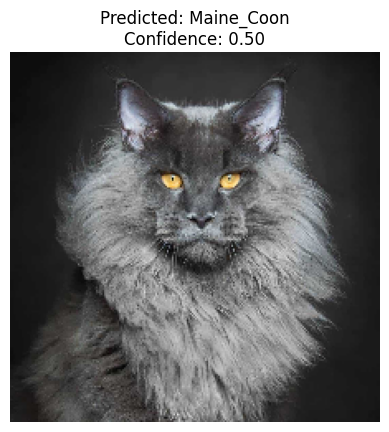

In [14]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load the saved model
model_path = '/content/cat_breed_model.keras'  # Make sure this matches your path
model = keras.models.load_model(model_path)
print("✅ Model loaded successfully.")

# ✅ Class names (12 cat breeds used in training)
class_names = [
    'Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair',
    'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll',
    'Russian_Blue', 'Siamese', 'Sphynx'
]

# ✅ Upload image
uploaded = files.upload()

# ✅ Predict for each uploaded image
for fname in uploaded.keys():
    img_path = fname
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    confidence = prediction[0][predicted_index]

    predicted_class = class_names[predicted_index]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()


In [ ]:
from google.colab import files

# Replace with your actual model filename if different
files.download("cat_breed_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define your target path in Drive
save_path = '/content/drive/MyDrive/CatBreedModel/cat_breed_model.keras'

# Step 3: Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Step 4: Save the model
model.save(save_path)

print(f"✅ Model saved to: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/CatBreedModel/cat_breed_model.keras
